In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 12, ASTR 596: Fundamentals of Data Science


## Intro to ML, contd. - Distances in Feature Space and Dimensionality Reduction

### Gautham Narayan 
##### <gsn@illinois.edu>

## <center> Questions about HW8 </center>
    
### The basic idea is straightforward:

### You can't model populations without accounting for how your sample was selected. 
### You can't model the selection effects without modeling the data accquistion process.
### This is conceptually straightforward but the implementation can get complex - take it step by step.

### Recap

#### Supervised learning needs labelled data
- Every algorithm will take features and labels for a training sample
- and optimize some metric you choose
- which results in a classifier with hyperparameters that are conditioned on the training sample
- that can then be applied to a test sample for prediction 

#### Tree methods are easy to interpret and are really useful in ensembles (random forests/boosted decision trees) 
- by no means the only, or even the best choice of ML algorithm (single decision trees are almost completely useless)
- if you are fortunate enough to have labelled data, decision tree ensembles like random forests are a good place to start

<img src="decision_tree.png" width="50%">

### Shortcomings:
- Can't deal well with missing data
- When dealing with predicting a categorical variable as output (i.e. class) it's hard to get $d\mathrm{class}/d\mathrm{parameter}$ so hard to incorporate uncertainty 
- Can be hard to construct training and testing sets that are representative - training data with labels often has different selection effects from test data

## But the biggest single issue - what do we do if we *don't* have labelled data?

### Something like entropy/Gini purity doesn't work because you don't have labels 
- in the cartoon, you don't know which points are (+) and (-)

<img src="entropy_twoclass.png">

### Without labels, you have no recourse but to find structure in the data itself

### Goal is still the same - partition the data into maximally homogenous and maximally distinguished subsets - except now without labels

<img src="cluster_vs_class.png">

### This is usually a more common problem in astrophysics - you have to get lucky to start with labelled data.


### ALSO, just because you do have labels, doesn't mean you should believe them:
To err is human.

<img src="Galileo_Neptune.png">



## Just as before, clustering requires some notion of a distance/metric

- members of the cluster should be similar/close to each other
- samples outside the cluster should be dissimilar/separated from cluster members

### Optimal clustering therefore depends on how you define this measure of similarity/distance and what the purpose of the clustering is.

### Ideally, we want clustering approaches to have 

- scalability (remember, we're dealing with big data i.e. high dimensional spaces with lots of samples)
    - spoiler: Naieve clustering approaches are NP hard
- ability to deal with different types of attributes
- ability to discover clusters with arbitrary shapes

<img src="HR_diagram.jpg">

- insensitivity to noise and outliers 
- insensitivity to order
- flexibility to incorporate constraints/priors
- be interpretable

So we'll have to think about more abstract notions of **distance**.

<img src="cluster_distance.png">

This map shows a spatial separation, but the feature space is 50-year mean monthly temperature, 50-year mean monthly precipitation, elevation, total plant-available water content of soil, total organic matter in soil, and total Kjeldahl soil nitrogen (i.e. the sum of ammonia + ammonium)

## Distances - continuous variables on ${\rm I\!R}$\:

### The Minkowski family:

## $$ D_p(i,j) =  \left({\sum_{k \mathrm{\, features}}|x_{i,k} - x_{j,k}|^p} \right)^{1/p} $$

Properties:
- $D(i, j) >= 0$ (see the absolute value symbols)
- $D(i, i) = 0$ (so similar things are close)
- $D(i, j) = D(j, i)$ (so order doesn't matter)
- $D(i, j) <= D(i, k) + D(k, j)$ (triangle inequality)

<img src="minkowski1.png">
Credit: Federica Bianco

<img src="minkowski2.png">
Credit: Federica Bianco

### NOTE: NOT ALL CONTINUOUS VARIABLES ARE DEFINED ON ${\rm I\!R}$:
<img src="minkowski_vs_gcd.png">
Credit: Federica Bianco

### OK, but some features aren't continuous at all

- e.g. you either have a spectral line or you don't
- a galaxy has some integer number of nearby companions 
- many variables affecting house prices

In this case, you can use the presence or absence of data to define a metric

###  Even categorical variables can be described as the presence or absence of data: [One hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
<img src="onehot.jpg">

<img src="cat1.png">
Credit: Federica Bianco

<img src="cat2.png">
Credit: Federica Bianco

### This is closely connected to something you've seen before

<img src="cat3.png">
Credit: Federica Bianco

## OK, so we've now got a way to get distances between our samples - regardless of if features are continuous/categorical 

### But do those distances actually measure something useful vis-a-vis sample similarity?

### Data can (and generally does) have covariance:

Attributes are not independent - they aren't telling you different things

[This can happen even with completely unrelated quantities:](https://www.tylervigen.com/spurious-correlations)

<img src="spurious_corr.png">

<img src="corr.png">

### Data Aquisition

From the SDSS Sky Server we've downloaded two types of photometry (aperature and petrosian), corrected for extinction, for a number of sources with redshifts. Here's the SQL for an example query, that gets us 10000 example quasars:

<font color="blue" size=2>
<pre>SELECT *,dered_u - mag_u AS diff_u, dered_g - mag_g AS diff_g, dered_r - mag_r AS diff_g, dered_i - mag_i AS diff_i, dered_z - mag_z AS diff_z from
(SELECT top 10000
objid, ra, dec, dered_u,dered_g,dered_r,dered_i,dered_z,psfmag_u-extinction_u AS mag_u,
psfmag_g-extinction_g AS mag_g, psfmag_r-extinction_r AS mag_r, psfmag_i-extinction_i AS mag_i,psfmag_z-extinction_z AS mag_z,z AS spec_z,dered_u - dered_g AS u_g_color, 
dered_g - dered_r AS g_r_color,dered_r - dered_i AS r_i_color,dered_i - dered_z AS i_z_color,class
FROM SpecPhoto 
WHERE (class = 'QSO') ) as sp
 </pre>
</font>


Credit: Phil Marshall

## In-class Exercise:

#### Feature covariance can cause all manner of issues if you are trying to assess the most important features or build a model that generalizes well from the training set to the test set.

#### Use the random forest regressor code from last class to train a model to predict redshifts from photometry - photo-zs. This is an active research problem because surveys like LSST will discover too many distant galaxies to get spectra of all of them (or even a large fraction of them) 


#### Look in particular at how well you generalize from the training set to the test set. This is how well we did last class for comparison

<img src="photoz_old.png">



#### There's some data below for QSOs from Phil Marshall that you can use to construct a training and test split with `sklearn`

In [2]:
# RUN THIS
import pandas as pd
pd.set_option('display.max_columns', None)
%pylab inline
import seaborn as sns
sns.set()
import copy

Populating the interactive namespace from numpy and matplotlib


/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# AND THIS
from astroML.decorators import pickle_results
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


qsos = pd.read_csv("qso10000.csv",index_col=0,usecols=["objid","dered_r","spec_z","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z"])

# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10)]


# Response variables: redshift
qso_redshifts = qsos["spec_z"]

# Features or attributes: photometric measurements
qso_features = copy.copy(qsos)
del qso_features["spec_z"]
qso_features.head()

,dered_r,u_g_color,g_r_color,r_i_color,i_z_color,diff_u,diff_g1,diff_i,diff_z
objid,,,,,,,,,
1237648720142532813,19.25328,0.331583,0.058027,0.099751,0.020077,-0.073151,-0.074903,-0.094942,-0.079136
1237658425156829371,19.16626,0.047575,0.181847,0.234743,-0.128612,-0.007589,-0.017090,-0.010700,-0.020636
1237660413189095710,18.70672,0.214582,0.182318,0.121645,-0.028202,-0.007397,0.002148,0.006218,-0.012548
1237660412651962520,19.52941,0.136745,0.222052,-0.120590,0.125301,0.001118,-0.005716,-0.020527,0.022139
1237658493336944662,18.15901,0.052462,0.247498,0.387709,0.011444,-0.098282,-0.244150,-0.238779,-0.271137


In [4]:
# We'll split the training and test set up, using 3000 QSOs for training and the rest for testing
mag = qso_features
z = qso_redshifts
mag_train, mag_test, z_train, z_test = train_test_split(mag, z, test_size=0.7, random_state=42)

@pickle_results: using precomputed results from 'photoz_forest.pkl'


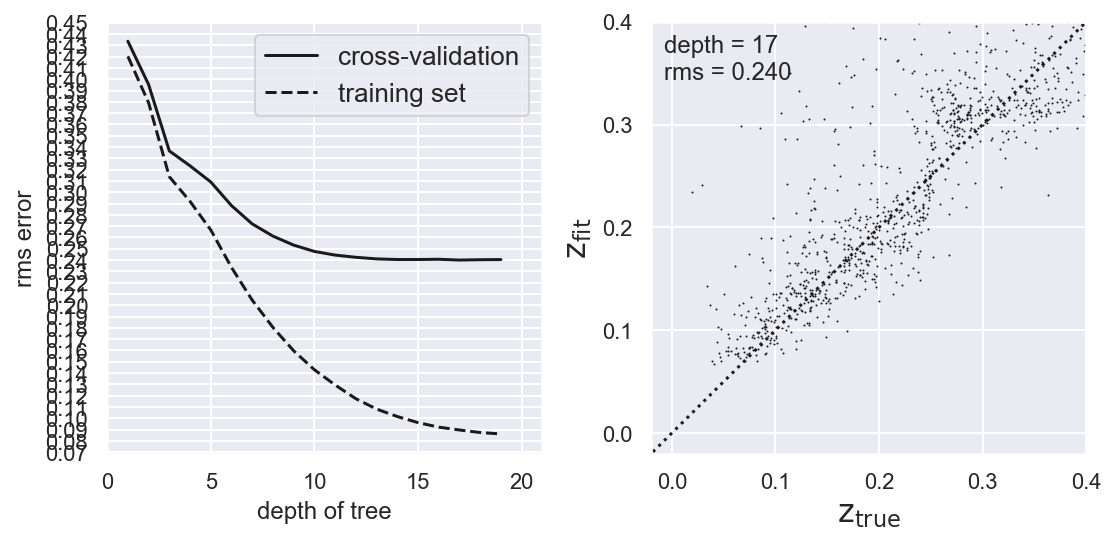

In [5]:
#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        
        ### YOU CAN CHANGE N_ESTIMATORS IF YOU LIKE 
        clf = RandomForestRegressor(n_estimators=100,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best, clf

depth = np.arange(1, 20)
rms_test, rms_train, i_best, z_fit_best, clf = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1, prop=dict(size=13))

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
#ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\rm z_{true}$', fontsize=16)
ax.set_ylabel(r'$\rm z_{fit}$', fontsize=16)

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

#### It's reasonable to ask why this is so much worse than our earlier result 

#### Part of why is that we were smarter about feature selection last time.

#### Let's plot the features in the dataset and their importances from the random forest:

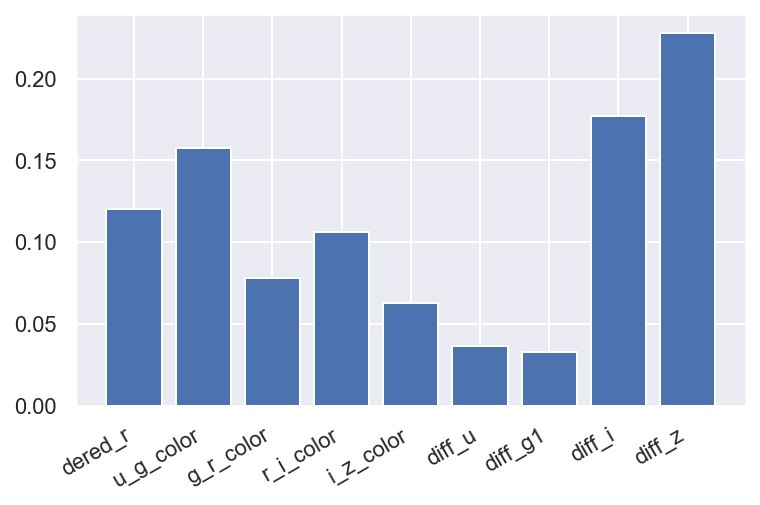

In [6]:
n_features = len(mag.columns)
bar(range(n_features), clf.feature_importances_ )
ax = plt.gca()
ax.set_xticks(range(n_features))
ax.set_xticklabels(list(mag.columns))
fig = plt.gcf()
fig.autofmt_xdate()

### The most important features here are `diff_i` and `diff_z`

### but lets look at them more closely - are they really independent of each other - do they really provide the random forest an indpendent split?

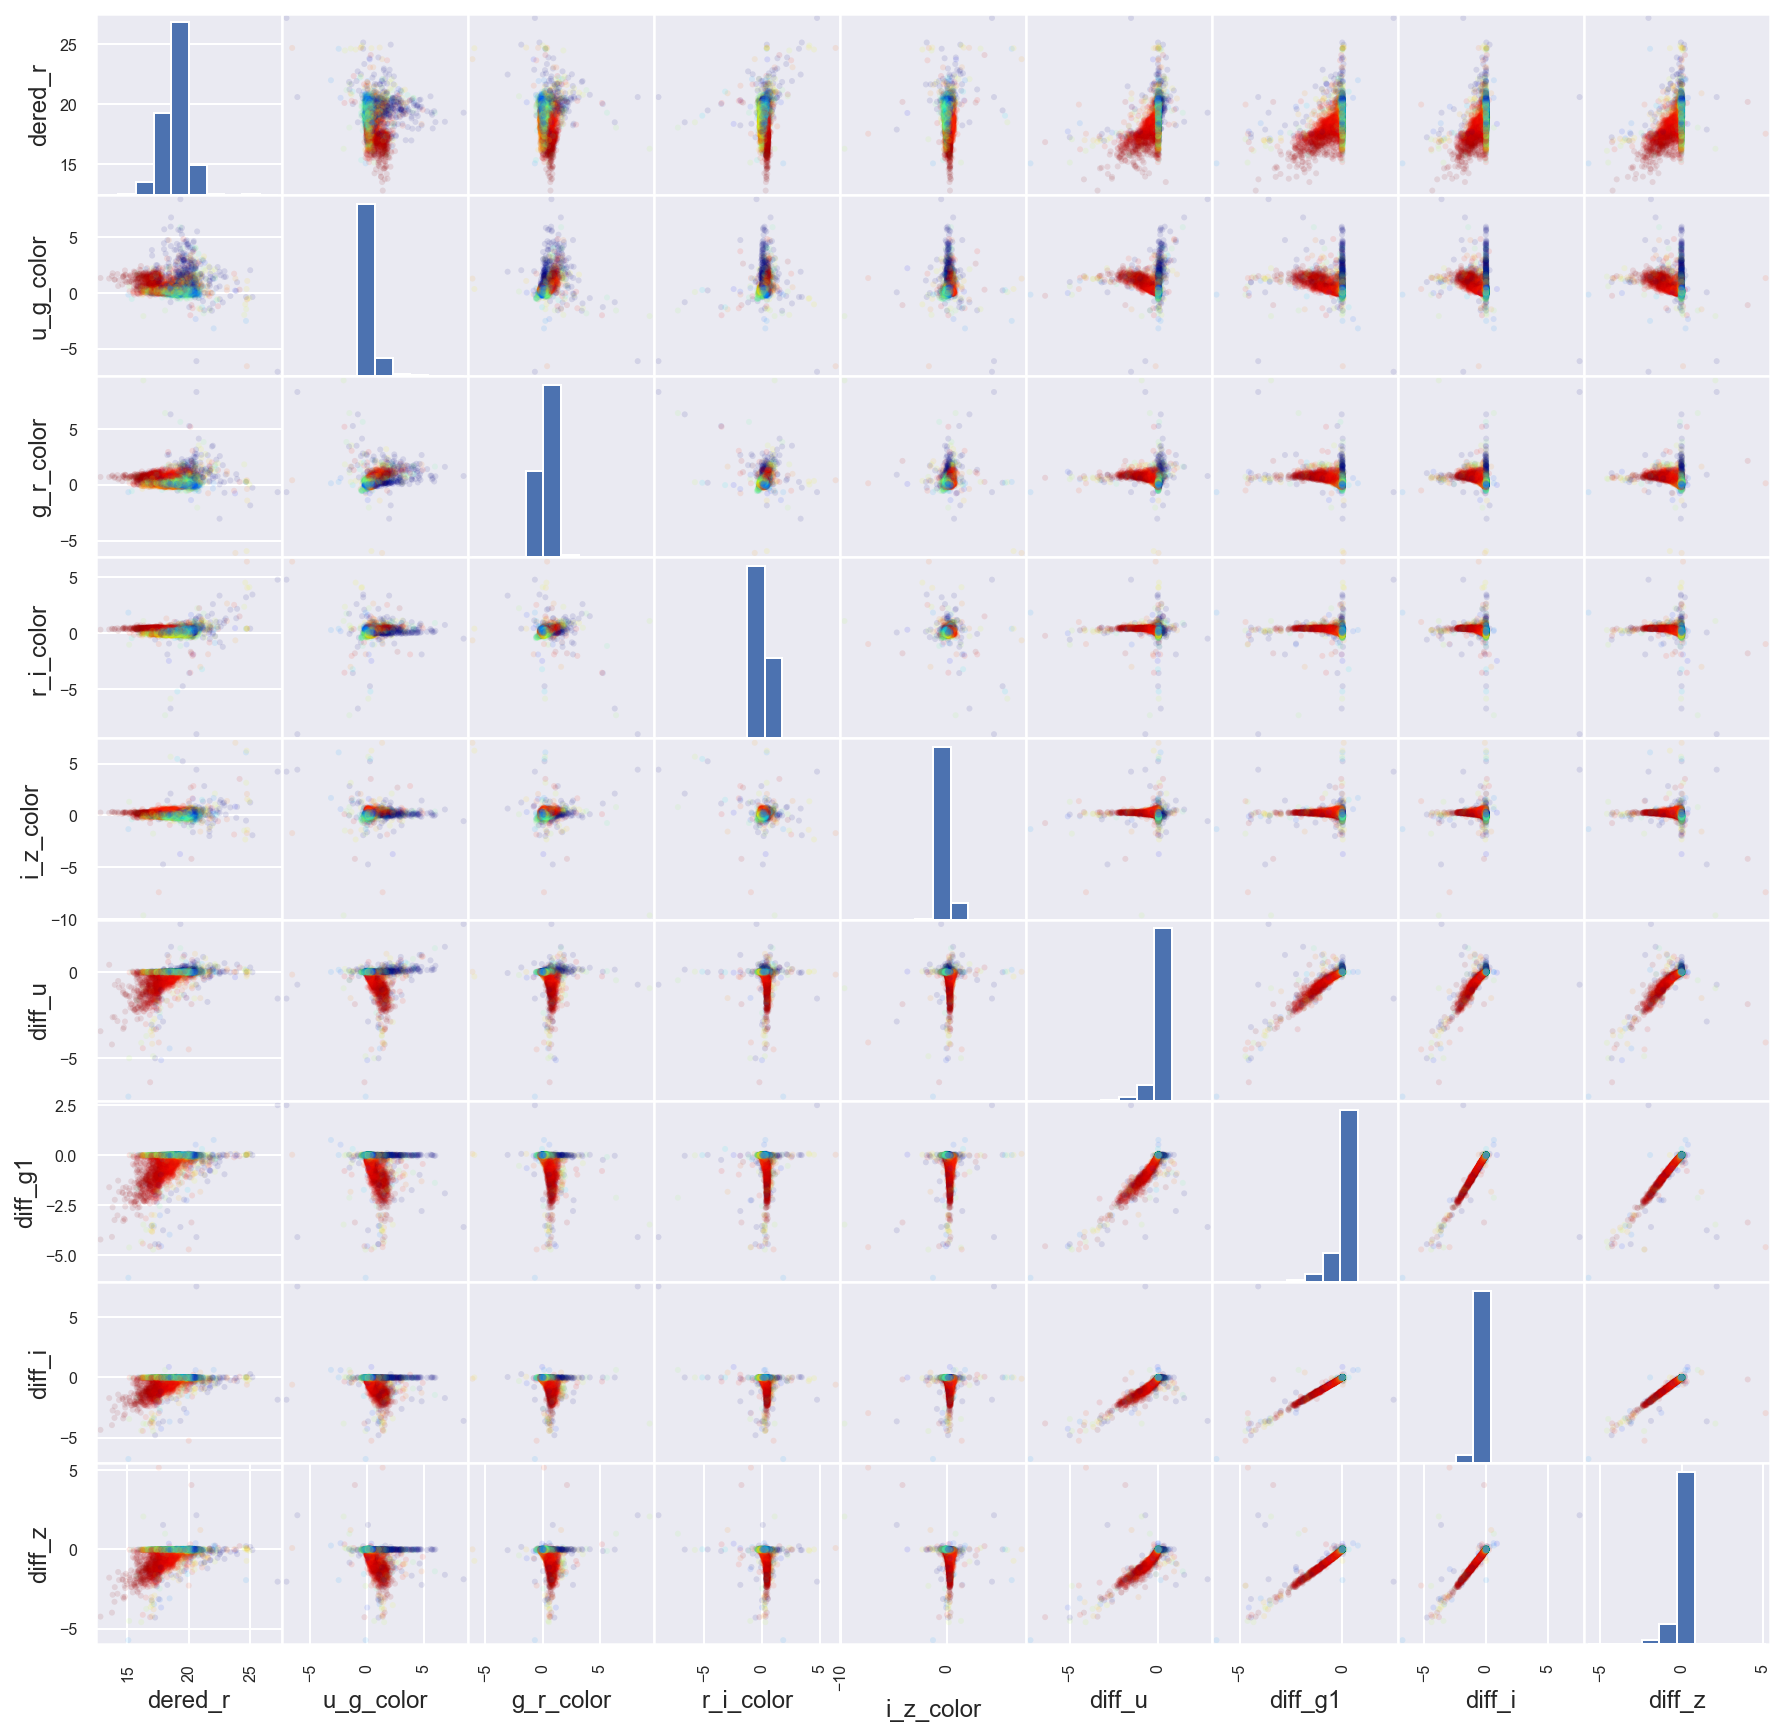

In [7]:
import matplotlib as mpl
import matplotlib.cm as cm

# Truncate the color at z=2.5 just to keep some contrast.
norm = mpl.colors.Normalize(vmin=min(qso_redshifts.values), vmax=2.5)
cmap = cm.jet_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot everything against everything else:
rez = pd.plotting.scatter_matrix(qso_features, alpha=0.1, figsize=[15,15], c=m.to_rgba(qso_redshifts.values))

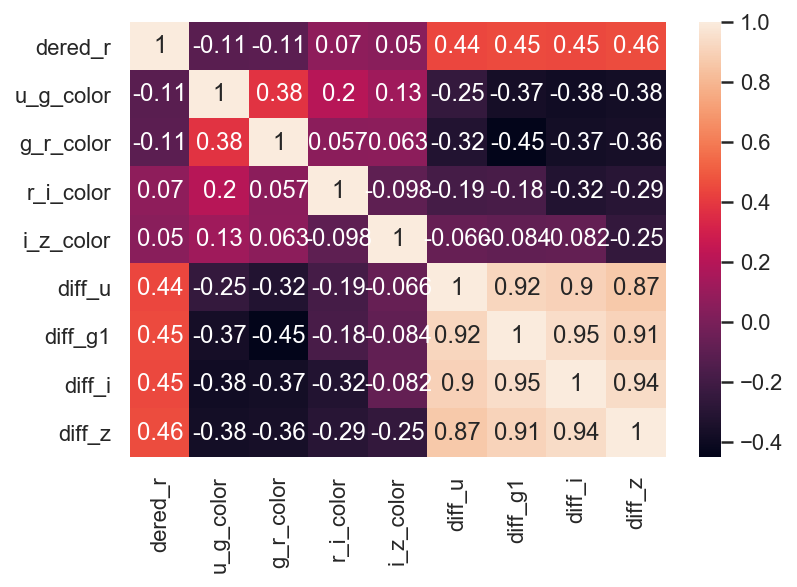

In [8]:
# AND THIS
corrMatrix = qso_features.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### This shouldn't be shocking - after all there is just an underlying SED - of course these features are strongly correlated. 

#### We never told the random forest that it should expect a priori that these features are not indpendent, so multiple trees in the forest are picking some combination of the same features (thus increasing their importance) without actually learning anything useful.

#### The message here is that you can train a model on features, but you should first consider if those features are all useful or if the model will overfit the same few features. 

#### Here we have a number of attributes/features/dimensions in our data that are tightly related - so we should try to reduce those correlations with *dimensionality reduction**

## Dimensionality Reduction##

Fitting and overfitting get worse with ''curse of dimensionality'' Bellman 1961

Think about a hypersphere. Its volume is  given by

\begin{equation}
  V_D(r) = \frac{2r^D\pi^{D/2}}{D\  \Gamma(D/2)},
\end{equation}

where $\Gamma(z)$ is the complete gamma function, $D$ is the dimension, and $r$ the radius of the sphere.


If you populated a hypercube of size $2r$ how much data would be enclosed by the hypersphere
- as $D$ increases the fractional volume enclosed by the hypersphere goes to 0! 

For example: the SDSS comprises a sample of 357 million sources. 
- each source has 448 measured attributes
- selecting just 30 (e.g., magnitude, size..) and normalizing the data range $-1$ to $1$

probability of having one of the 357 million sources reside within a unit hypersphere 1 in 1.4$\times 10^5$.

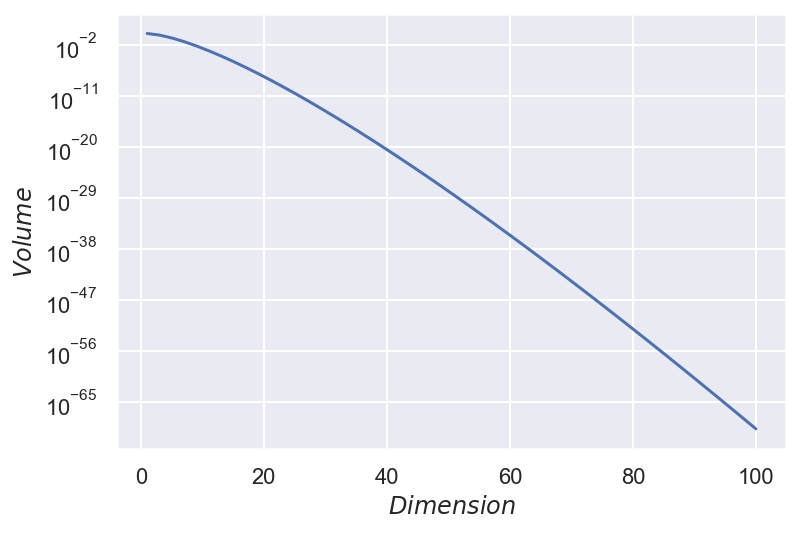

In [9]:
%matplotlib inline
import numpy as np
import scipy.special as sp
from matplotlib import pyplot as plt

def unitVolume(dimension, radius=1.):
    return 2*(radius**dimension *np.pi**(dimension/2.))/(dimension*sp.gamma(dimension/2.))

dim = np.linspace(1,100)

#------------------------------------------------------------
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dim,unitVolume(dim)/2.**dim)

ax.set_yscale('log')
ax.set_xlabel('$Dimension$')
ax.set_ylabel('$Volume$')

plt.show()


In [10]:
D=30;unitVolume(D)/(2.**D)

2.041026339664143e-14

## What can we do to reduce the dimensions##

**Principal component analysis or the Karhunen-Loeve transform**

The first refuge of a scoundrel...

<img width="500" src="pca-scatter.png">

Points are  correlated along a particular direction which doesn't align with the initial choice of axes. 
- we should rotate our axes to align with this correlation. 
- rotation preserves the relative ordering of data

Choose  rotation to maximize the ability to discriminate between the data points
*   first axis, or <u>principal component</u>, is direction of maximal variance
*   second principal component is orthogonal to the first component and maximizes the residual variance
*   ...

## Derivation of principal component analyses##

Set of data $X$: $N$ observations by $K$ measurements

Center data by subtracting the mean 

The covariance is

>$ 
C_X=\frac{1}{N-1}X^TX,
$

$N-1$ as the sample covariance matrix 

We want a projection, $R$,  aligned with the directions of maximal variance ($Y= X R$) with covariance 

>$
C_{Y} = R^T X^T X R = R^T C_X R
$

Derive  principal component by maximizing its variance (using Lagrange multipliers and constraint)

> $
\phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1).
$

derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ set to 0

> $
C_Xr_1 - \lambda_1 r_1 = 0.
$

$\lambda_1$ is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ and the largest eigenvalue

>$
\lambda_1 =  r_1^T C_X r_1
$

Other  principal components  derived by
applying additional constraint that components are uncorrelated (e.g., $r^T_2 C_X r_1 = 0$).

## Lagrangian mulitpliers
<img width="500" src="LagrangeMultipliers2D.png">

## Computation of principal components##

Common approach is eigenvalue decomposition of the covariance or correlation matrix,
or singular value decomposition (SVD) of the data matrix

** SVD given by**

>$
U \Sigma V^T = \frac{1}{\sqrt{N - 1}} X,
$

columns of $U$ are  _left-singular vectors_

columns of $V$ are the _right-singular vectors_

The columns of $U$ and $V$ form orthonormal bases ($U^TU = V^TV = I$)

Covariance matrix is

> $
\begin{eqnarray}
  C_X &=& \left[\frac{1}{\sqrt{N - 1}}X\right]^T \left[\frac{1}{\sqrt{N - 1}}X\right]\nonumber\\
      &=& V \Sigma U^T U \Sigma V^T\nonumber\\
      &=& V \Sigma^2 V^T.
\end{eqnarray}
$

right singular vectors $V$ are the principal components. We can calculate principal components from the SVD of $X$ - we dont need $C_X$.

<img width="500" src="fig_svd_visual_1.png">
Singular value decomposition (SVD) can factorize an N x K matrix into $U \Sigma V^T$. There are different conventions for computing the SVD in the literature, and this figure illustrates the convention used in this text. The matrix of singular values $\Sigma$ is always a square matrix of size [R x R] where R = min(N, K). The shape of the resulting U and V matrices depends on whether N or K is larger. The columns of the matrix U are called the left-singular vectors, and the columns of the matrix V are called the right-singular vectors. The columns are orthonormal bases, and satisfy $U^T U = V^T V = I$.

## Preparing data for PCA##

- Center data by subtracting the mean of each dimension
- For heterogeneous data (e.g., galaxy shape and flux) divide by  variance (whitening). **why?**
- For spectra or images normalize each row so integrated flux of each object is one.  

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA 
from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra.shape

(4000, 1000)

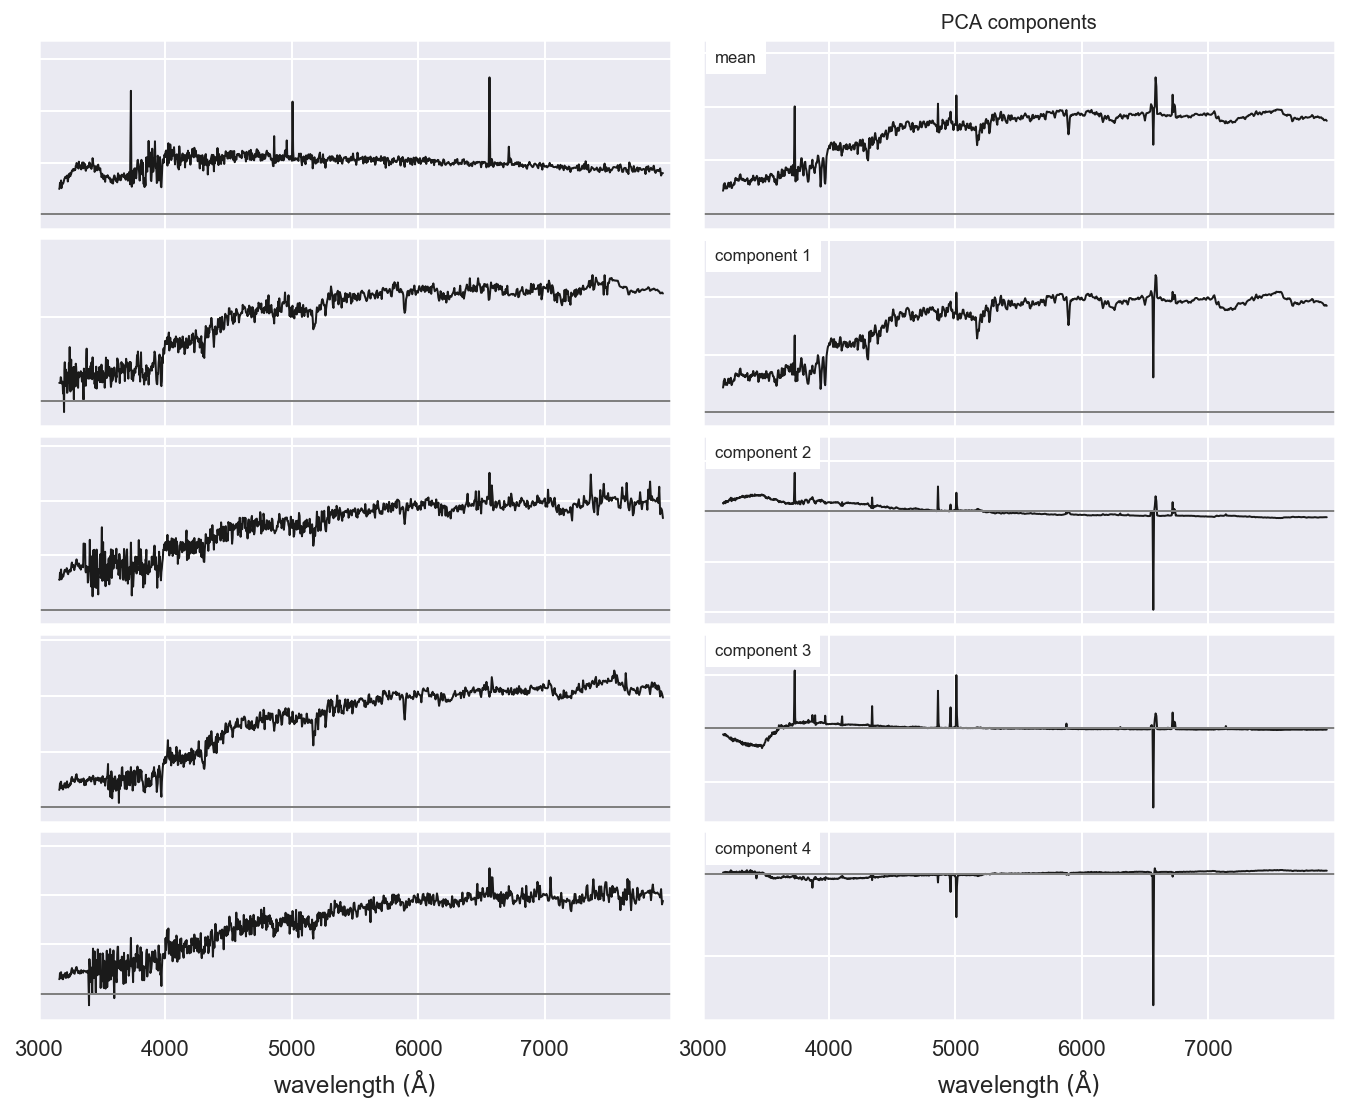

In [12]:
#----------------------------------------------------------------------
# Compute PCA
def compute_PCA(n_components=5):
#    np.random.seed(500)
    nrows = 500
    ind = np.random.randint(spectra.shape[0], size=nrows)
    
    spec_mean = spectra[ind].mean(0)
#    spec_mean = spectra[:50].mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1)
    pca.fit(spectra[ind])
    pca_comp = np.vstack([spec_mean,
                          pca.components_])
    evals = pca.explained_variance_ratio_

    return pca_comp, evals

n_components = 5
decompositions, evals = compute_PCA(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = 'PCA components'

for j in range(n_components):
    ax = fig.add_subplot(n_components, 2, 2*j+2)

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax.plot(wavelengths, decompositions[j], '-k', lw=1)

    # plot zero line
    xlim = [3000, 7999]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax2 = fig.add_subplot(n_components, 2, 2*j+1)
    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    ax2.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax2.set_xlabel(r'wavelength ${\rm (\AA)}$')
    ax2.plot(wavelengths, spectra[j], '-k', lw=1)
    
    # plot zero line
    ax2.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax2.set_xlim(xlim)

    if j == 0:
        ax.set_title(titles, fontsize='medium')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    # adjust y limits
    ylim = plt.ylim()
    dy = 0.05 * (ylim[1] - ylim[0])    
    ax2.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)


    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='w', fc='w'),
            fontsize='small')


    

plt.show()

## Interpreting the PCA##

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

>$ \begin{equation}
  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),
\end{equation}
$

Truncating this expansion (i.e., $r<R$)

>$\begin{equation}
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
\end{equation}
$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

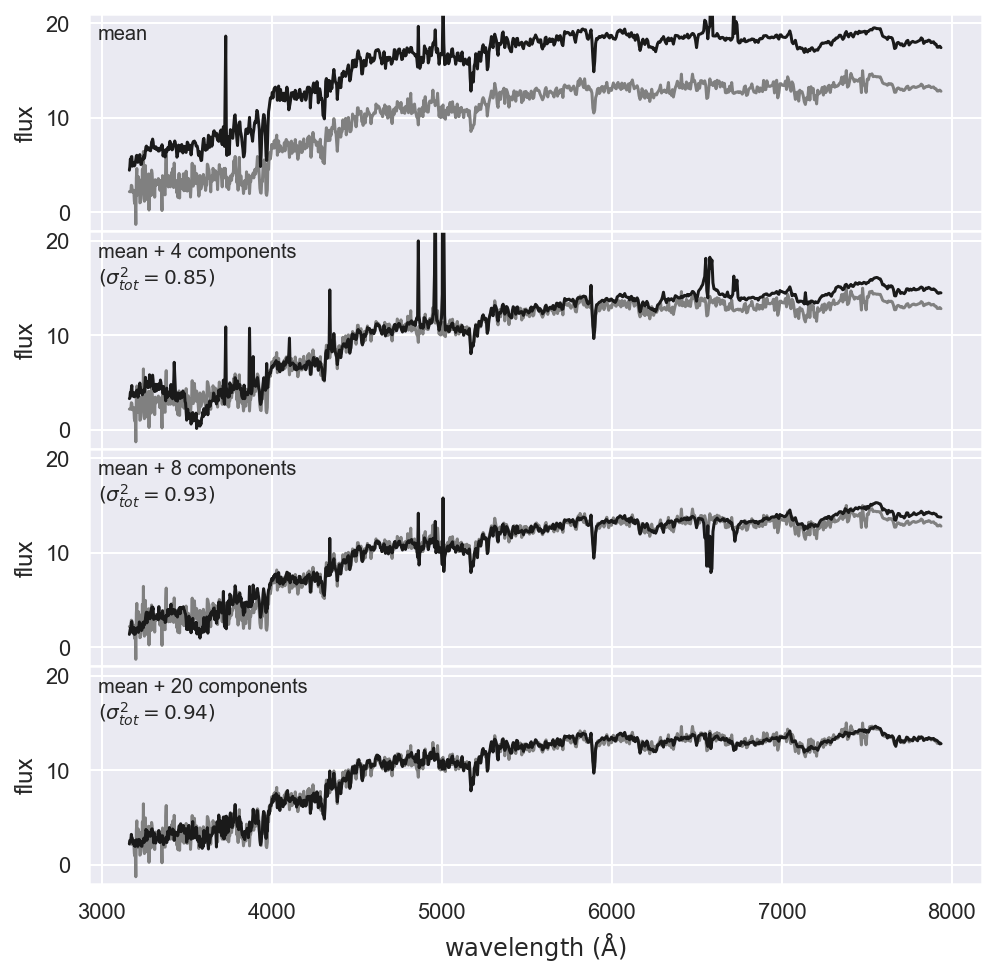

In [13]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA, KernelPCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.01, 0.95, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

- k-means
- GMMs
- EM
- hierarchical clustering -> trees
- DBScan